In [1]:
#导入数据包

import matplotlib.pyplot as plt
import h5py
import numpy as np
from sklearn.utils import shuffle
from keras.applications import *
from keras.preprocessing.image import *
from keras.layers import *
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import *
import os

np.random.seed(2017)

Using TensorFlow backend.


In [2]:
#参数设置
img_size_1 = (299,299)
img_size_2 = (224,224)
img_path ='./blood_cell_data/'
save_path_inceptionv3 = './merged_features/merged_featurs_inceptionv3.h5'
save_path_xception = './merged_features/merged_featurs_xception.h5'
save_path_inceptionresnetv2 = './merged_features/merged_featurs_inceptionresnetv2.h5'
feature_files = [save_path_inceptionv3,save_path_xception,save_path_inceptionresnetv2]

In [3]:
#通过经典模型+GlobalAveragePooling获取特征向量

def write_feature_vectors(MODEL,img_size, img_path, save_path,lambda_func):
    x = Input((img_size[0],img_size[1], 3))
    x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x,weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    print("start{}".format(save_path))
    gen = ImageDataGenerator()
    features_generator = gen.flow_from_directory(img_path,img_size, shuffle=False,batch_size = 64)
    features = model.predict_generator(features_generator,156)
    with h5py.File(save_path) as h:
        h.create_dataset("features", data = features)
        h.create_dataset("y",data = features_generator.classes)
    print("finished")
print("finished")

finished


In [4]:
#选取inceptionv3, xception, inceptionresnetv2获取特征向量并存储在h5文件中
#write_feature_vectors(inception_v3.InceptionV3,img_size_1, img_path, save_path_inceptionv3, lambda_func=inception_v3.preprocess_input)        
#write_feature_vectors(xception.Xception,img_size_1, img_path, save_path_xception, lambda_func=xception.preprocess_input)
#write_feature_vectors(inception_resnet_v2.InceptionResNetV2,img_size_1, img_path, save_path_inceptionresnetv2, lambda_func=inception_resnet_v2.preprocess_input)
#生成一次后面注释掉调参

In [5]:
#读取三个模型的特征向量，拼接融合在一起   
X_features = []    
    
for filename in feature_files:
    with h5py.File(filename, 'r') as h:
        X_features.append(np.array(h['features']))        
        y = np.array(h['y'])
                
X_features = np.concatenate(X_features, axis=1)

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
encoded_y = np_utils.to_categorical(encoded_y)


rows = len(y)
row_indices = np.random.permutation(rows)

split_index = int(rows*0.9)

X_train,X_test = X_features[row_indices[0:split_index],:],X_features[row_indices[split_index:],:]

encoded_y_train, encoded_y_test = encoded_y[row_indices[0:split_index]],encoded_y[row_indices[split_index:]]

print("finished")

finished


In [6]:
#构建模型
#以特征向量为输入，构建神经网络，加BN,Dropout防止过拟合

input_tensor = Input(X_train.shape[1:])
x = Dropout(0.4)(input_tensor)
x = Dense(1200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(16, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=x)

model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5632)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5632)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1200)              6759600   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1200)              4800      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               307456    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
__________

In [7]:
batch_size=128
epochs=700

#from keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=0, mode='auto')

#训练
history = model.fit(X_train, encoded_y_train, batch_size=batch_size,shuffle=True, epochs=epochs, validation_split=0.2)
print("finished")

Train on 7168 samples, validate on 1793 samples
Epoch 1/700
7168/7168 [==============================] - 3s 371us/step - loss: 1.1053 - acc: 0.5306 - val_loss: 0.9758 - val_acc: 0.6308
Epoch 2/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.7361 - acc: 0.7083 - val_loss: 0.9278 - val_acc: 0.6648
Epoch 3/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.5699 - acc: 0.7803 - val_loss: 0.4736 - val_acc: 0.8109
Epoch 4/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.4674 - acc: 0.8209 - val_loss: 0.3632 - val_acc: 0.8555
Epoch 5/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.3862 - acc: 0.8623 - val_loss: 0.2915 - val_acc: 0.8912
Epoch 6/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.3320 - acc: 0.8764 - val_loss: 0.2706 - val_acc: 0.8924
Epoch 7/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.2900 - acc: 0.8979 - val_loss: 0.3074 - val_acc: 0.8840

7168/7168 [==============================] - 1s 84us/step - loss: 0.0421 - acc: 0.9855 - val_loss: 0.0804 - val_acc: 0.9771
Epoch 61/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0434 - acc: 0.9851 - val_loss: 0.0456 - val_acc: 0.9861
Epoch 62/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0465 - acc: 0.9849 - val_loss: 0.0902 - val_acc: 0.9710
Epoch 63/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0417 - acc: 0.9847 - val_loss: 0.0789 - val_acc: 0.9704
Epoch 64/700
7168/7168 [==============================] - 1s 86us/step - loss: 0.0418 - acc: 0.9845 - val_loss: 0.0684 - val_acc: 0.9749
Epoch 65/700
7168/7168 [==============================] - 1s 85us/step - loss: 0.0341 - acc: 0.9872 - val_loss: 0.0847 - val_acc: 0.9743
Epoch 66/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0456 - acc: 0.9855 - val_loss: 0.0518 - val_acc: 0.9827
Epoch 67/700
7168/7168 [==============================

Epoch 120/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0204 - acc: 0.9923 - val_loss: 0.0352 - val_acc: 0.9905
Epoch 121/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0201 - acc: 0.9939 - val_loss: 0.0501 - val_acc: 0.9849
Epoch 122/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0215 - acc: 0.9918 - val_loss: 0.0497 - val_acc: 0.9855
Epoch 123/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0229 - acc: 0.9932 - val_loss: 0.0494 - val_acc: 0.9827
Epoch 124/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0213 - acc: 0.9922 - val_loss: 0.0717 - val_acc: 0.9777
Epoch 125/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0205 - acc: 0.9927 - val_loss: 0.0348 - val_acc: 0.9888
Epoch 126/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0301 - acc: 0.9902 - val_loss: 0.0597 - val_acc: 0.9788
Epoch 127/700
7168/7168 [=========

7168/7168 [==============================] - 1s 85us/step - loss: 0.0156 - acc: 0.9936 - val_loss: 0.0390 - val_acc: 0.9888
Epoch 180/700
7168/7168 [==============================] - 1s 86us/step - loss: 0.0132 - acc: 0.9953 - val_loss: 0.0373 - val_acc: 0.9866
Epoch 181/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0172 - acc: 0.9934 - val_loss: 0.0304 - val_acc: 0.9894
Epoch 182/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0166 - acc: 0.9932 - val_loss: 0.0310 - val_acc: 0.9877
Epoch 183/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0176 - acc: 0.9946 - val_loss: 0.0273 - val_acc: 0.9883
Epoch 184/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0225 - acc: 0.9920 - val_loss: 0.0229 - val_acc: 0.9888
Epoch 185/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0178 - acc: 0.9927 - val_loss: 0.0354 - val_acc: 0.9877
Epoch 186/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 82us/step - loss: 0.0149 - acc: 0.9943 - val_loss: 0.0320 - val_acc: 0.9905
Epoch 239/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0126 - acc: 0.9954 - val_loss: 0.0335 - val_acc: 0.9916
Epoch 240/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0139 - acc: 0.9954 - val_loss: 0.0356 - val_acc: 0.9883
Epoch 241/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0110 - acc: 0.9969 - val_loss: 0.0213 - val_acc: 0.9933
Epoch 242/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0162 - acc: 0.9947 - val_loss: 0.0308 - val_acc: 0.9872
Epoch 243/700
7168/7168 [==============================] - 1s 85us/step - loss: 0.0141 - acc: 0.9948 - val_loss: 0.0366 - val_acc: 0.9855
Epoch 244/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0155 - acc: 0.9943 - val_loss: 0.0222 - val_acc: 0.9911
Epoch 245/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 83us/step - loss: 0.0168 - acc: 0.9950 - val_loss: 0.0312 - val_acc: 0.9877
Epoch 298/700
7168/7168 [==============================] - 1s 85us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.0297 - val_acc: 0.9894
Epoch 299/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0132 - acc: 0.9957 - val_loss: 0.0395 - val_acc: 0.9883
Epoch 300/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.0242 - val_acc: 0.9922
Epoch 301/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0111 - acc: 0.9960 - val_loss: 0.0303 - val_acc: 0.9888
Epoch 302/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0136 - acc: 0.9960 - val_loss: 0.0442 - val_acc: 0.9872
Epoch 303/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0178 - acc: 0.9954 - val_loss: 0.0379 - val_acc: 0.9883
Epoch 304/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 82us/step - loss: 0.0110 - acc: 0.9967 - val_loss: 0.0353 - val_acc: 0.9883
Epoch 357/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0081 - acc: 0.9976 - val_loss: 0.0301 - val_acc: 0.9922
Epoch 358/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0112 - acc: 0.9957 - val_loss: 0.0407 - val_acc: 0.9872
Epoch 359/700
7168/7168 [==============================] - 1s 81us/step - loss: 0.0067 - acc: 0.9973 - val_loss: 0.0274 - val_acc: 0.9888
Epoch 360/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0097 - acc: 0.9969 - val_loss: 0.0279 - val_acc: 0.9922
Epoch 361/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0129 - acc: 0.9953 - val_loss: 0.0307 - val_acc: 0.9900
Epoch 362/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0119 - acc: 0.9962 - val_loss: 0.0268 - val_acc: 0.9905
Epoch 363/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 83us/step - loss: 0.0107 - acc: 0.9961 - val_loss: 0.0309 - val_acc: 0.9888
Epoch 416/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0098 - acc: 0.9965 - val_loss: 0.0256 - val_acc: 0.9944
Epoch 417/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0313 - val_acc: 0.9911
Epoch 418/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0120 - acc: 0.9962 - val_loss: 0.0306 - val_acc: 0.9888
Epoch 419/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0076 - acc: 0.9979 - val_loss: 0.0171 - val_acc: 0.9939
Epoch 420/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0236 - val_acc: 0.9944
Epoch 421/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0073 - acc: 0.9975 - val_loss: 0.0290 - val_acc: 0.9916
Epoch 422/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 83us/step - loss: 0.0094 - acc: 0.9967 - val_loss: 0.0269 - val_acc: 0.9922
Epoch 475/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0095 - acc: 0.9971 - val_loss: 0.0212 - val_acc: 0.9933
Epoch 476/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0053 - acc: 0.9979 - val_loss: 0.0290 - val_acc: 0.9911
Epoch 477/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0093 - acc: 0.9969 - val_loss: 0.0274 - val_acc: 0.9911
Epoch 478/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0242 - val_acc: 0.9939
Epoch 479/700
7168/7168 [==============================] - 1s 81us/step - loss: 0.0097 - acc: 0.9973 - val_loss: 0.0158 - val_acc: 0.9967
Epoch 480/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0055 - acc: 0.9980 - val_loss: 0.0219 - val_acc: 0.9916
Epoch 481/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 82us/step - loss: 0.0065 - acc: 0.9979 - val_loss: 0.0205 - val_acc: 0.9922
Epoch 534/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0733 - val_acc: 0.9777
Epoch 535/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0090 - acc: 0.9982 - val_loss: 0.0171 - val_acc: 0.9939
Epoch 536/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0221 - val_acc: 0.9916
Epoch 537/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0059 - acc: 0.9980 - val_loss: 0.0208 - val_acc: 0.9922
Epoch 538/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0057 - acc: 0.9982 - val_loss: 0.0236 - val_acc: 0.9927
Epoch 539/700
7168/7168 [==============================] - 1s 84us/step - loss: 0.0081 - acc: 0.9971 - val_loss: 0.0223 - val_acc: 0.9911
Epoch 540/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 82us/step - loss: 0.0063 - acc: 0.9985 - val_loss: 0.0240 - val_acc: 0.9933
Epoch 593/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0251 - val_acc: 0.9933
Epoch 594/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0091 - acc: 0.9971 - val_loss: 0.0213 - val_acc: 0.9944
Epoch 595/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0272 - val_acc: 0.9911
Epoch 596/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0059 - acc: 0.9976 - val_loss: 0.0176 - val_acc: 0.9955
Epoch 597/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0090 - acc: 0.9972 - val_loss: 0.0262 - val_acc: 0.9922
Epoch 598/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0064 - acc: 0.9983 - val_loss: 0.0334 - val_acc: 0.9911
Epoch 599/700
7168/7168 [=======================

7168/7168 [==============================] - 1s 88us/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0228 - val_acc: 0.9916
Epoch 652/700
7168/7168 [==============================] - 1s 91us/step - loss: 0.0050 - acc: 0.9976 - val_loss: 0.0218 - val_acc: 0.9944
Epoch 653/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0072 - acc: 0.9973 - val_loss: 0.0194 - val_acc: 0.9933
Epoch 654/700
7168/7168 [==============================] - 1s 81us/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0249 - val_acc: 0.9933
Epoch 655/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0046 - acc: 0.9983 - val_loss: 0.0204 - val_acc: 0.9933
Epoch 656/700
7168/7168 [==============================] - 1s 83us/step - loss: 0.0042 - acc: 0.9990 - val_loss: 0.0227 - val_acc: 0.9939
Epoch 657/700
7168/7168 [==============================] - 1s 82us/step - loss: 0.0070 - acc: 0.9982 - val_loss: 0.0168 - val_acc: 0.9955
Epoch 658/700
7168/7168 [=======================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


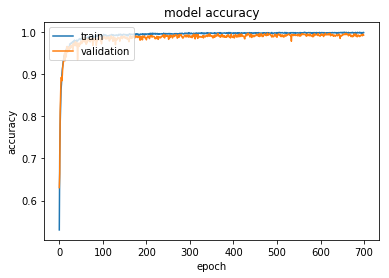

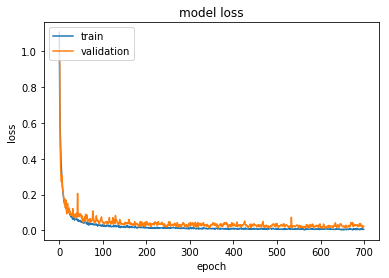

In [8]:
print(history.history.keys())

# 可视化valication trend
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 可视化loss trend
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import accuracy_score
y_pred = np.rint(model.predict(X_test))
print(f'Accuracy Score:{accuracy_score(encoded_y_test, y_pred)}')

Accuracy Score:0.9939759036144579


In [10]:
from sklearn.metrics import confusion_matrix
y_pred_unencoded = np.argmax(y_pred, axis=1)
y_test_unencoded = np.argmax(encoded_y_test, axis=1)
print(f'Confusion matrix:\n{confusion_matrix(y_test_unencoded, y_pred_unencoded)}')     

Confusion matrix:
[[249   0   0   2]
 [  0 265   0   0]
 [  0   0 237   0]
 [  3   1   0 239]]
